In [1]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

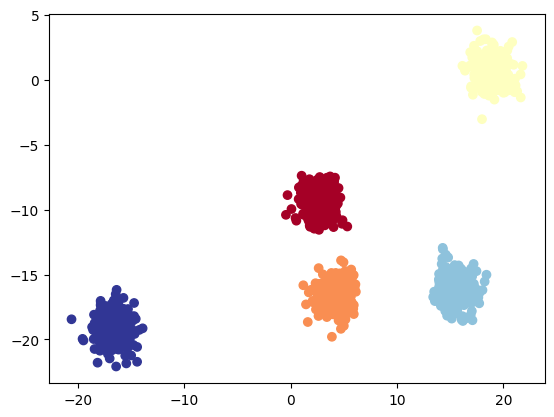

In [178]:
#Creating Data
NUM_CLASSES = 5 #Try changing thees values!
NUM_FEATURES = 2 #Dimension?
circle_amount = 1200
#! The X and y is still in numpy form
X, y = make_blobs(
    n_samples=circle_amount,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    random_state=129,
    center_box=(-20, 20),
)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=128)

#Making them to tensors
X_train = torch.from_numpy(X_train).type(torch.float32).to(device=device).squeeze()
X_test = torch.from_numpy(X_test).type(torch.float32).to(device=device).squeeze()
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device=device).squeeze()
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device=device).squeeze()

In [179]:
class Classifactor(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.linear_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=8),
        nn.Linear(in_features=8, out_features=8),
        #nn.Tanh(),  #Why don't I need tanh? softmax is doin the job?
        nn.Linear(in_features=8, out_features=out_features),
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
       return self.linear_stack(x)

model_3 = Classifactor(in_features=NUM_FEATURES, out_features=NUM_CLASSES).to(device=device)

In [180]:
y_logits = model_3(X_train)[:5]
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred = y_pred_probs.argmax(dim=1)[:5]

In [181]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.3)
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc
#optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.3)

In [182]:
#Training model
torch.manual_seed(128)

epochs = 100

for epoch in range(epochs):
    #Training
    model_3.train()
    y_logits = model_3(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = y_pred_probs.argmax(dim=1)
    loss = loss_fn(y_logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Test
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_pred = test_pred_probs.argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
    if epoch % 10:
        print(f"epoch: {epoch}, loss: {loss} {accuracy_fn(y_pred=y_pred, y_true=y_train)}%, test loss: {test_loss} {accuracy_fn(y_pred=test_pred, y_true=y_test)}%")




epoch: 1, loss: 4.445615768432617 32.604166666666664%, test loss: 10.461334228515625 40.0
epoch: 2, loss: 9.664908409118652 40.0%, test loss: 15.45108413696289 48.333333333333336
epoch: 3, loss: 12.539372444152832 57.395833333333336%, test loss: 4.397756099700928 57.49999999999999
epoch: 4, loss: 4.033997535705566 60.62499999999999%, test loss: 8.241676330566406 57.08333333333333
epoch: 5, loss: 7.584650039672852 60.62499999999999%, test loss: 15.494039535522461 35.833333333333336
epoch: 6, loss: 14.624578475952148 40.833333333333336%, test loss: 21.143102645874023 59.166666666666664
epoch: 7, loss: 19.242246627807617 60.20833333333333%, test loss: 12.98840618133545 45.416666666666664
epoch: 8, loss: 11.808565139770508 49.47916666666667%, test loss: 16.650571823120117 35.0
epoch: 9, loss: 14.130338668823242 41.25%, test loss: 10.705245018005371 35.0
epoch: 11, loss: 6.391650199890137 51.24999999999999%, test loss: 2.6885406970977783 47.5
epoch: 12, loss: 2.437831163406372 51.4583333333

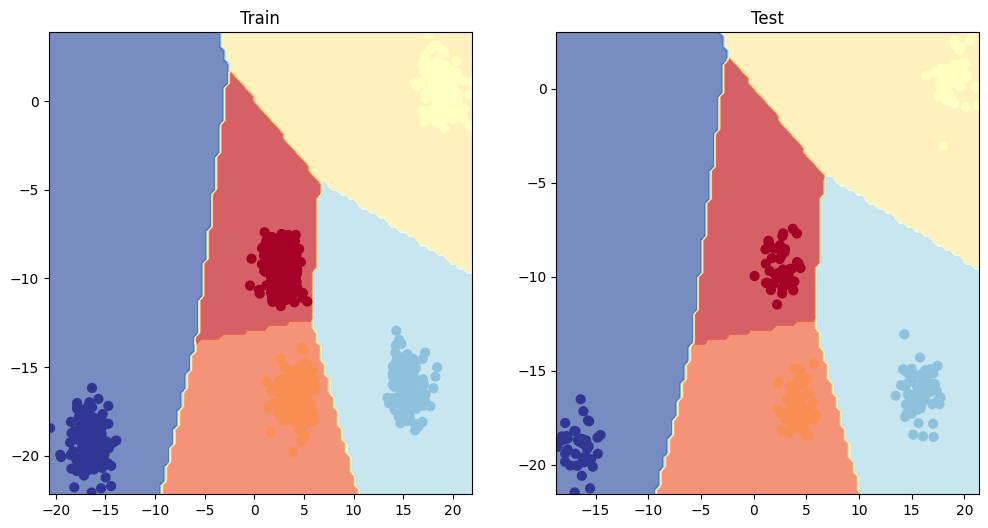

In [183]:
from helper_functions import plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) 